### Replication power simulation

Strategy:

- sample subjects from wessel replication 1 in order to create a dataset with particular N (using fabricatr
- fit lmer to dataset 
- create 3 simulated datasets using appropriate value for interaction beta
- run lmer on simulated datasets after combining (simulating our 3 sites)
- store pvalue and cohen's d for observed effect


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
import seaborn as sns
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()
lme4 = importr('lme4')
stats = importr('stats')
lmerTest = importr('lmerTest')
EMAtools = importr('EMAtools')
fabricatr = importr('fabricatr')
%load_ext rpy2.ipython



/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
%%R -o rep1Df
options(bitmapType='cairo')
library('tidyverse')
rep1Df = read_delim('../processed_data/study-1_task-auction_data.tsv', '\t')
rep1Df['X1'] = NULL
rep1Df = rep1Df %>% 
  mutate(studyNum = 1,
         stimValueFactor = as.factor(auctionStimValue))


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  auctionStimValue = col_double(),
  auctionCondition = col_character(),
  chosenAuctionAmount = col_double(),
  subcode = col_character()
)



In [3]:
run_ez = r('''run_ez = function(summaryDf){
library(ez)
summaryDf['auctionStimValue'] = as.factor(summaryDf$auctionStimValue)
summaryDf['auctionCondition'] = as.factor(summaryDf$auctionCondition)
summaryDf['site'] = as.factor(summaryDf$site)
summaryDf['subcode_unique'] = as.factor(summaryDf$subcode_unique)

#Run an ANOVA on the mean correct RT data.
CombinedExclusiveAuctionANOVA = ezANOVA(
  data = summaryDf
  , dv = chosenAuctionAmount
  , wid = subcode_unique
  , within = .(auctionStimValue,auctionCondition)
  , between = site
  , detailed = TRUE
)
}
''')

In [4]:
formula = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 + auctionStimValue*auctionCondition|subcode_unique)"""
formula_multisite = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 + auctionStimValue*auctionCondition|subcode_unique) + (1|site)"""

# formula for random intercept model on summary data
formula_summary = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 |subcode_unique) + (1|site)"""

n = 79
int_param_max = 4
int_param_min = 1.5
results_sim = pd.DataFrame(columns=['int_param', 'cohensd_int', 'int_pval'])

nruns = 1000
import time
now = time.time()
et = []


for i in range(nruns):
    int_param = np.random.rand()*int_param_max
    if i > 0:
        et.append(time.time() - now)
        print(i, int_param, et[-1], 'eta:', (nruns - i)*np.mean(et)/60, 'mins')
        now = time.time()
    simDf = fabricatr.resample_data(rep1Df, n, r("c('subcode')"), True)
    m1 = lme4.lmer(formula=formula, data=simDf)
    # coefs = lmerTest.get_coefmat(m1)
    coefs=r('list(beta=c(139,10,0,%f))' % int_param)
    s = lme4.simulate_merMod(m1, newparams=coefs, nsim=3)
    simDf1 = simDf.copy()
    simDf2 = simDf.copy()
    simDf3 = simDf.copy()
    simDf1['chosenAuctionAmount'] = s.sim_1.values
    simDf2['chosenAuctionAmount'] = s.sim_2.values
    simDf3['chosenAuctionAmount'] = s.sim_3.values
    simDf1['site'] = 'a'
    simDf2['site'] = 'b'
    simDf3['site'] = 'c'
    simDf1['subcode_unique'] = ['%s_a' % i for i in simDf1['subcode_unique']]
    simDf2['subcode_unique'] = ['%s_b' % i for i in simDf2['subcode_unique']]
    simDf3['subcode_unique'] = ['%s_c' % i for i in simDf3['subcode_unique']]
  
    simDfall = simDf1.append(simDf2).append(simDf3)
    
    sm1 = lme4.lmer(formula=formula_multisite, data=simDfall)
    sm1_coefs = lmerTest.get_coefmat(sm1)
    results_sim.loc[i, 'int_pval'] = sm1_coefs[3,4]
    results_sim.loc[i, 'cohensd_int'] = EMAtools.lme_dscore(
        sm1, simDfall, 'lme4').loc['auctionStimValue:auctionConditionstop', 'd']
    results_sim.loc[i, 'int_param'] = int_param

    # create summary data for simple rmANOVA
    summaryDf = simDfall.groupby(['subcode_unique', 'site',
                               'auctionStimValue', 
                               'auctionCondition']).mean().reset_index()

    # use ezanova
    ez = run_ez(summaryDf)
    results_sim.loc[i, 'int_pval_ez'] = ez[2].query(
        'Effect=="auctionStimValue:auctionCondition"').loc[:, "p[HF]"].values[0]

    # fit lmer model with random intercept to summary data
    sm3 = lme4.lmer(formula=formula_summary, data=summaryDf)
    sm3_coefs = lmerTest.get_coefmat(sm3)
    results_sim.loc[i, 'int_pval_simple'] = sm3_coefs[3,4]
    results_sim.loc[i, 'cohensd_int_simple'] = EMAtools.lme_dscore(
        sm3, summaryDf, 'lme4').loc[
            'auctionStimValue:auctionConditionstop', 'd']

results_sim.to_csv('power_sim_mixedmodel1.csv')

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



1 0.782313390709283 54.46309041976929 eta: 906.8104554891586 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



2 3.987588310973331 56.03469800949097 eta: 918.9732737700144 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



3 3.8232833792882794 55.28513026237488 eta: 918.2531663086679 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



4 2.3272076409847195 54.19593381881714 eta: 912.912237918377 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



5 1.3254917338486663 55.241299867630005 eta: 912.8135053873062 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



6 0.45378588866693015 54.933043479919434 eta: 911.5896574523714 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



7 0.8178289616428835 58.077024698257446 eta: 917.8871643151556 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



8 2.5901125183673726 52.248936891555786 eta: 910.3235920588176 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



9 2.765279481851799 53.29163932800293 eta: 906.1608511200659 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



10 0.1395322153458145 54.15289831161499 eta: 904.0740968942642 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



11 2.1202967693205665 57.09989094734192 eta: 906.6186766490792 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



12 2.417130547896596 54.74785757064819 eta: 905.353036502997 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



13 1.481480307377483 53.6225049495697 eta: 902.7177272099715 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



14 2.9601819750463085 54.24464130401611 eta: 901.0614876202175 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



15 2.625864479209382 57.08944225311279 eta: 902.6190129227109 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



16 3.885695463583318 52.65065598487854 eta: 899.3131552994251 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



17 1.743911034416414 55.76577949523926 eta: 899.2951094540895 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



18 1.0645517527859534 55.615835428237915 eta: 899.0394607093599 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



19 2.7625850139789465 53.81133437156677 eta: 897.1603300715748 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



20 2.0129575604018672 54.948880672454834 eta: 896.3084230860075 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



21 0.9988556485755953 54.13808345794678 eta: 894.820453087678 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



22 3.852439528192223 56.74802088737488 eta: 895.3194520581853 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



23 1.977791288848017 53.25810217857361 eta: 893.2220550165661 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



24 2.6989930976091636 57.108593463897705 eta: 893.8352489021089 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



25 2.6296785961993074 57.38818407058716 eta: 894.5049763798713 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



26 1.464083375564062 55.14574980735779 eta: 893.6495278077248 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



27 2.8341150725171924 55.60973596572876 eta: 893.0680427301078 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



28 0.4825926708235375 55.12707734107971 eta: 892.1826377442904 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



29 1.454851739105941 53.624366998672485 eta: 890.4563492533805 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



30 3.977033700564634 53.709675788879395 eta: 888.8315359910329 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



31 0.1843868961329509 53.30630421638489 eta: 887.043653473931 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



32 1.7038172338681545 55.77447247505188 eta: 886.5563543776672 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



33 0.1742539771628535 55.53683829307556 eta: 885.9261940150551 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



34 1.335017421660769 58.317352056503296 eta: 886.5953090751872 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



35 3.5658784885935955 54.23419737815857 eta: 885.2943418610664 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



36 2.357900625913322 55.47168588638306 eta: 884.5677202917911 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



37 1.1529419090155768 56.81100559234619 eta: 884.4113762420577 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



38 0.06429099037878849 55.32035160064697 eta: 883.5844752338895 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



39 1.1972448269216622 54.39380240440369 eta: 882.3721783454602 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



40 3.429513710508586 53.354758977890015 eta: 880.7595507621766 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



41 0.2141131398675169 56.16897630691528 eta: 880.2792972482316 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



42 0.07892766263329953 55.38534212112427 eta: 879.4794290196328 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



43 0.1526234736720884 57.49832582473755 eta: 879.4575991272926 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



44 2.6364963336185805 58.69218683242798 eta: 879.8255245602492 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



45 3.351259350770003 56.036999464035034 eta: 879.1944724515632 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



46 0.06428437674471077 56.51480984687805 eta: 878.7154070672782 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



47 2.319242208823579 58.23115921020508 eta: 878.7966747218835 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



48 3.3156570680219857 55.954753398895264 eta: 878.0816393315793 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



49 3.8305755582310455 54.64076066017151 eta: 876.9326881744423 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



50 0.9825172059410772 55.62800312042236 eta: 876.105894668897 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



51 2.098953405940857 56.95276141166687 eta: 875.6860145074091 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



52 1.472044834930851 52.98535943031311 eta: 874.0402955697134 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



53 0.10501809752196589 57.951509952545166 eta: 873.9022684868028 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



54 2.213862591427951 58.53095984458923 eta: 873.9027660421383 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



55 1.5545388906910298 52.865346908569336 eta: 872.2453466729686 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



56 3.1874014094455916 55.247931241989136 eta: 871.2850461255936 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



57 2.2099070076212337 53.246439933776855 eta: 869.7742584143466 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



58 2.604116440456976 55.309253454208374 eta: 868.8433477093434 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



59 2.704196360987326 57.728965282440186 eta: 868.5559510179158 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



60 3.145920190318989 56.629067182540894 eta: 867.9588669538498 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



61 1.5547240412718564 53.22128915786743 eta: 866.4761239794433 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



62 1.2820969812780474 54.97543549537659 eta: 865.4549067693372 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



63 0.9474806330719918 58.194122076034546 eta: 865.2348812312677 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



64 0.5001002076406396 54.15948557853699 eta: 864.0079794064164 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



65 2.231597477482892 54.01068711280823 eta: 862.7553808334545 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



66 1.0085380522380727 57.7014799118042 eta: 862.3839668384705 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



67 1.4615803401013725 53.84182858467102 eta: 861.099147876163 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



68 3.539653924058843 56.79597210884094 eta: 860.5005437135696 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



69 3.7191059808492657 55.902154207229614 eta: 859.6908516497427 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



70 3.184029531854466 53.67123556137085 eta: 858.3836844427245 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



71 2.837348281823679 57.516930103302 eta: 857.9267913726014 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



72 0.19573661983483603 57.33084011077881 eta: 857.4159866809845 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



73 1.7600505992200652 56.274996519088745 eta: 856.6695353850926 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



74 1.282308023255577 56.213043212890625 eta: 855.9049884587795 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



75 1.1978594806499046 54.87001657485962 eta: 854.8597792890337 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



76 2.7279554200469796 55.04472374916077 eta: 853.8534110175937 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



77 0.6855736454383736 56.66205143928528 eta: 853.1724687641318 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



78 1.5795383452831064 52.97257423400879 eta: 851.7579134731211 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



79 3.061419599006154 54.771363496780396 eta: 850.706329995922 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



80 0.9686179574435725 56.79879069328308 eta: 850.0468049168587 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



81 2.1848137200499314 53.63687610626221 eta: 848.782289286896 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



82 3.8595677776762685 53.5398633480072 eta: 847.5087107324018 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



83 3.7181855993382467 53.64926266670227 eta: 846.2644632773226 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



84 2.8500948120638916 56.71680784225464 eta: 845.5860655345615 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



85 0.5770884835313814 54.297704219818115 eta: 844.4673725562936 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



86 2.9155786520869706 55.59604597091675 eta: 843.583627661254 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



87 0.4877753013059136 54.066415548324585 eta: 842.4313587661447 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



88 2.280377387806059 56.41582894325256 eta: 841.6906058658254 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



89 2.0463879491848975 55.42737913131714 eta: 840.7767407766443 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



90 0.5106775773322267 52.979966163635254 eta: 839.4502207341018 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



91 2.463020870947965 55.711992502212524 eta: 838.5882857491682 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



92 0.6728479382817354 51.980427742004395 eta: 837.1110876140388 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



93 2.805292817610393 56.84384369850159 eta: 836.4375491909656 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



94 1.3179594208166936 59.36218333244324 eta: 836.1627257735171 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



95 1.799193179276866 59.21921420097351 eta: 835.8501597910597 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



96 3.239238407395171 53.76353693008423 eta: 834.6673051344023 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



97 2.801307217541931 53.929311990737915 eta: 833.5160845610284 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



98 1.4597176531421554 55.830827951431274 eta: 832.661710117139 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



99 2.2720539583083013 56.76238131523132 eta: 831.9470987806818 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



100 1.245698806663547 55.631701946258545 eta: 831.058256971836 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



101 3.3947160699504146 54.544342279434204 eta: 830.0073460660752 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



102 2.0780866122961634 53.81689119338989 eta: 828.8524759362725 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



103 3.060648547646801 58.534544944763184 eta: 828.3873608304459 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



104 1.2902687293745227 55.76467728614807 eta: 827.5147045869094 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



105 0.1598143183593539 53.95008850097656 eta: 826.3831804754242 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



106 1.7408315893317883 53.42277264595032 eta: 825.1819177384647 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



107 2.3054267072041954 52.36013722419739 eta: 823.8386569565702 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



108 2.2517161133789916 56.65337896347046 eta: 823.0950941146154 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



109 0.4812911921864389 54.16803431510925 eta: 822.0092497285353 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



110 1.9448892098522106 57.08847999572754 eta: 821.320551086917 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



111 0.1412041986046173 56.85225296020508 eta: 820.5955853345515 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



112 1.6803388593250945 53.208160638809204 eta: 819.38510431477 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



113 3.031072665090826 55.320053815841675 eta: 818.4566425647707 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



114 0.24753675954530907 59.50569987297058 eta: 818.070469953512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



115 1.7620729377528521 55.80042862892151 eta: 817.1985240469808 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



116 1.75703587765814 54.14013457298279 eta: 816.1147006556906 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



117 0.9967862998883779 54.31647515296936 eta: 815.0561603512858 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



118 1.5321871775801266 54.674339294433594 eta: 814.044799151259 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



119 1.848004322093523 54.92436766624451 eta: 813.0659715171955 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



120 1.9513589767678652 54.75829315185547 eta: 812.0679029120339 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



121 0.7611052504731943 59.499938011169434 eta: 811.6453380916729 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



122 2.3209050931558712 54.28179574012756 eta: 810.5875518216461 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



123 3.867637698591574 54.99270176887512 eta: 809.6167351109872 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



124 0.9478113455647712 54.54692363739014 eta: 808.5943069700272 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



125 2.2583935451194277 56.53214621543884 eta: 807.8053011337917 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



126 2.159189525913305 53.75294876098633 eta: 806.6925648521495 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



127 1.0704997122174609 53.08266353607178 eta: 805.5064510711535 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



128 0.9400015195526019 56.827560901641846 eta: 804.7502485960722 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



129 2.531298485175081 55.032390117645264 eta: 803.789071369356 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



130 1.842836893851687 53.4626739025116 eta: 802.6534868836403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



131 3.4595725872789647 54.29132342338562 eta: 801.613251154174 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



132 0.26416536806068924 53.20500469207764 eta: 800.4560104981817 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



133 3.8152490819195193 54.84408617019653 eta: 799.4809180265082 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



134 0.08782358902038379 56.11992049217224 eta: 798.6441583218859 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



135 3.418233422735548 53.98621869087219 eta: 797.5780800080594 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



136 0.8400711066360147 52.90896487236023 eta: 796.4003852311303 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



137 2.1738443917290358 57.70789432525635 eta: 795.7308390626363 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



138 1.0085783178040009 59.13472533226013 eta: 795.2055994254955 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



139 0.567975530603205 52.53063464164734 eta: 793.9919469851385 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



140 3.6379890797529972 54.91814160346985 eta: 793.0275603793915 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



141 3.8351303349904704 52.5057635307312 eta: 791.8189252328647 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



142 1.8378418929908795 54.905739545822144 eta: 790.8566755454306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



143 1.9365363054579605 56.77847909927368 eta: 790.0821410422282 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



144 3.6399040681846078 54.9438591003418 eta: 789.1234575185512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



145 0.9316920426564086 56.11954689025879 eta: 788.2809081747614 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



146 1.1437469888292378 54.25934982299805 eta: 787.2557399419345 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



147 3.3448464077724083 54.15631127357483 eta: 786.222250802717 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



148 3.1637959625900294 56.047278881073 eta: 785.371961041399 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



149 2.1333119063808 54.09420704841614 eta: 784.3346328107302 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



150 1.1664971704610192 53.608399391174316 eta: 783.2532328539424 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



151 3.336034676966453 59.74271011352539 eta: 782.7491597182703 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



152 0.6028359030780295 54.35778260231018 eta: 781.7379138662104 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



153 0.7976611814751737 54.50240135192871 eta: 780.7413876239511 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



154 3.4760758138690444 54.289149045944214 eta: 779.7264811755774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



155 2.3329124964903296 56.24453830718994 eta: 778.8906622972539 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



156 1.6446770536511015 59.14247393608093 eta: 778.3148505620467 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



157 3.4190479325831906 56.33725094795227 eta: 777.4827765637143 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



158 1.2470098829929306 56.40067267417908 eta: 776.6549826783973 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



159 1.7923040013292542 55.20873546600342 eta: 775.7207018673795 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



160 3.315342877107456 57.42303133010864 eta: 774.9803486347198 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



161 0.9585708319315374 54.55331063270569 eta: 773.9880596525921 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



162 2.839593126216878 52.37658333778381 eta: 772.8091318416007 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



163 2.0730715511315427 54.515756607055664 eta: 771.8170349301005 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



164 1.1075703819587113 54.64334297180176 eta: 770.8367959776546 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



165 3.9796351756987494 55.341909885406494 eta: 769.9163191829065 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



166 2.2238017752488424 55.64950609207153 eta: 769.0215761865478 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



167 3.0015428070261962 53.90995812416077 eta: 767.9818258738327 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



168 2.030775135913609 54.387094497680664 eta: 766.9831398055667 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



169 2.6152308986384267 56.34089803695679 eta: 766.145664672245 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



170 0.8267949359372899 53.08783745765686 eta: 765.0422851211885 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



171 0.1746521442447282 53.91481256484985 eta: 764.0082810316402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



172 1.6826557986074944 54.876755237579346 eta: 763.0530307597892 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



173 1.3646634834073006 55.441486835479736 eta: 762.1432438360703 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



174 0.5983178048908941 55.05110478401184 eta: 761.2024067095413 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



175 2.836700544648006 54.210023641586304 eta: 760.1957511356899 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



176 2.391778908301342 56.42823672294617 eta: 759.3633556187153 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



177 3.723403557568023 55.48208522796631 eta: 758.4564166279386 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



178 3.8418140322675405 56.71657586097717 eta: 757.6442922259984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



179 2.253371037940281 58.04082918167114 eta: 756.931910259142 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



180 2.2440598258504703 53.02082347869873 eta: 755.8355467646211 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



181 0.33525291235997967 54.81872773170471 eta: 754.8771211665638 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



182 2.472086645153015 53.62269330024719 eta: 753.829594602515 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



183 0.6378850987051514 53.505879640579224 eta: 752.7750572043255 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



184 2.757900464794658 54.1875901222229 eta: 751.7726763714915 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



185 0.7092372139077328 55.22407293319702 eta: 750.847470674751 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



186 3.9285719628171565 53.66811776161194 eta: 749.8088267188773 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



187 3.9085150310674948 53.667179584503174 eta: 748.7716567648924 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



188 0.5141789903460063 55.38983201980591 eta: 747.8600116170044 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



189 3.431932198883988 51.757596254348755 eta: 746.6884788631131 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



190 0.3914755886409722 54.80470609664917 eta: 745.7367029259079 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



191 1.730986346604769 55.861512899398804 eta: 744.8599322595313 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



192 3.7066467745830667 54.17165732383728 eta: 743.864071849154 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



193 1.2823255018824846 55.53111529350281 eta: 742.963914592155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



194 0.4822478654192426 55.7906014919281 eta: 742.0814637368898 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



195 0.49958640919071096 54.50600028038025 eta: 741.1101418495178 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



196 0.21913883036740645 55.39584279060364 eta: 740.2002978536548 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



197 2.0062724883544982 54.79736256599426 eta: 739.2496594393111 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



198 0.09318794494429206 53.09127736091614 eta: 738.1842231756508 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



199 0.4692354190351917 57.25612998008728 eta: 737.400002719769 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



200 0.011496145234492605 53.28450417518616 eta: 736.3493067264557 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



201 2.367835633051711 57.97414827346802 eta: 735.6109274947822 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



202 2.6630041433712406 56.777586221694946 eta: 734.7915087164038 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



203 1.158354099292263 54.60822033882141 eta: 733.8288871853418 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



204 1.629516202619901 53.27383780479431 eta: 732.7800017364664 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



205 2.408521390434407 54.145116090774536 eta: 731.7890012319496 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



206 1.3665201928015835 53.21122860908508 eta: 730.738868297651 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



207 0.524711616631949 60.16127252578735 eta: 730.13406373057 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



208 3.4334571329282597 54.03972506523132 eta: 729.1369505428352 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



209 3.5349132781291734 54.086512327194214 eta: 728.1437115860898 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



210 2.386035421801019 53.4642333984375 eta: 727.1123309862047 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



211 2.9346458520574714 55.37633180618286 eta: 726.2014466619039 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



212 0.4547083642435683 56.92597556114197 eta: 725.3864485588463 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



213 0.7802787853554425 52.96859049797058 eta: 724.3264962911979 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



214 3.7884939233879202 53.213512659072876 eta: 723.2831924588882 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



215 1.4523317493639087 54.93030595779419 eta: 722.3458151516988 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



216 0.47673169710370633 53.86400055885315 eta: 721.3441354704493 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



217 1.1892004049804643 54.3688747882843 eta: 720.3737760720165 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



218 0.6322149366914855 54.414387941360474 eta: 719.4067268160869 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



219 3.557006885401595 54.25344800949097 eta: 718.4306610493536 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



220 0.5951829936940825 54.870516777038574 eta: 717.4917115428232 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



221 3.5288518722511317 54.420896768569946 eta: 716.5265688930522 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



222 0.6961757359282981 56.193859815597534 eta: 715.6655058660307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



223 0.48416733033043435 56.21279263496399 eta: 714.8048651592079 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



224 0.7394528185930636 52.668060302734375 eta: 713.7388776525146 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



225 2.1470860980297073 53.181081771850586 eta: 712.7040141472111 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



226 0.6509086517672946 54.47002673149109 eta: 711.7440374306873 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



227 0.9985710153361667 53.5179545879364 eta: 710.7304854854963 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



228 1.3372697734774235 56.23035216331482 eta: 709.8710681347819 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



229 2.7171674433039374 52.148836612701416 eta: 708.7819434251327 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



230 2.9659658789525447 58.0169563293457 eta: 708.0221556338711 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



231 3.4124247369236707 54.9001841545105 eta: 707.0876451023385 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



232 3.936430750425208 54.08839559555054 eta: 706.1085144042969 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



233 0.9575188381887916 53.53877878189087 eta: 705.0998960665197 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



234 3.471496857413604 56.21168565750122 eta: 704.2381013262985 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



235 3.6286973631970096 56.94596600532532 eta: 703.4155063352686 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



236 0.25568762817921 57.27605867385864 eta: 702.6096493573513 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



237 2.1656250266908863 53.49796485900879 eta: 701.5998166508311 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



238 2.737330911308762 55.13361692428589 eta: 700.6782578146758 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



239 2.215441527762846 56.323410511016846 eta: 699.8198616525784 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



240 2.7411515671196343 52.812785148620605 eta: 698.77551309069 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



241 3.149429732857163 53.247873306274414 eta: 697.7553642638491 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



242 1.0138130878301954 54.35188889503479 eta: 696.7939458728822 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



243 3.7778658410452826 51.33605599403381 eta: 695.6764013449515 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



244 3.9733196359183074 53.991758584976196 eta: 694.6981426360177 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



245 1.6922049438986861 55.30295395851135 eta: 693.7878676029289 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



246 0.4184599814782821 56.28966188430786 eta: 692.9279045530451 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



247 3.300241292855124 55.99589562416077 eta: 692.0523821407002 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



248 2.8764863111509564 54.21824669837952 eta: 691.0865558913958 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



249 2.8467174349989617 56.23803186416626 eta: 690.2227591813169 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



250 2.6132800150854223 55.09432625770569 eta: 689.301189160347 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



251 3.5076556563940406 59.67087364196777 eta: 688.6072575019808 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



252 1.7314463829069013 53.82723641395569 eta: 687.6218502751733 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



253 2.4466106032853667 58.14193534851074 eta: 686.8494650838403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



254 2.6536228189822983 53.862186431884766 eta: 685.8660372193092 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



255 0.10831458298592311 56.850390672683716 eta: 685.0287857685214 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



256 2.6285466842982412 51.41089487075806 eta: 683.9271973721683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



257 1.932951034658839 52.98448395729065 eta: 682.9033356625282 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



258 2.621206107997743 54.979843616485596 eta: 681.9762085332735 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



259 1.6249782605121101 60.035714626312256 eta: 681.2902458819183 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



260 2.1627265459998397 56.005173444747925 eta: 680.4106706417523 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



261 3.4508005912684077 52.941572189331055 eta: 679.3861105583029 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



262 0.8050530832938447 54.17325234413147 eta: 678.4204591275171 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



263 3.7009949788374144 56.63714671134949 eta: 677.570360410017 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



264 0.8580428852524551 58.86747622489929 eta: 676.8231821517752 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



265 0.5467077349012412 53.800418853759766 eta: 675.8400063633919 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



266 2.996574084097986 54.4704167842865 eta: 674.8882941550779 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



267 3.4221944671008466 59.16296935081482 eta: 674.1516197534238 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



268 1.9037502386679428 57.47214126586914 eta: 673.3361138114288 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



269 1.9503653182967318 53.63757133483887 eta: 672.3458771266163 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



270 2.9070347170712147 57.705918073654175 eta: 671.5396803417323 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



271 2.3684588505178636 53.59842228889465 eta: 670.5481801958981 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



272 2.9467787825052145 51.62862491607666 eta: 669.4695336459898 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



273 1.4175938111201893 55.31484389305115 eta: 668.5560923178408 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



274 0.6494558733858855 52.877766132354736 eta: 667.5349663678747 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



275 0.596536968899926 53.98178505897522 eta: 666.5633672847893 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



276 0.00378506052175398 59.631438970565796 eta: 665.8392910128055 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



277 2.86332806396514 54.41327977180481 eta: 664.8862675190402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



278 2.1855714009956984 53.513349771499634 eta: 663.8946221307599 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



279 3.9929666988135106 53.668033838272095 eta: 662.9103541593967 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



280 0.6624088330738522 54.09326887130737 eta: 661.9449519804546 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



281 1.8113287766349733 54.00432014465332 eta: 660.9762109871155 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



282 0.31844213256739407 55.76915740966797 eta: 660.0828478563762 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



283 2.727495713095501 52.7006573677063 eta: 659.0596585024794 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



284 3.9531370864720015 52.3154878616333 eta: 658.0213048317622 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



285 0.978466035114038 58.126869916915894 eta: 657.2271096191909 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



286 0.8867927930770327 55.46331596374512 eta: 656.3208673298775 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



287 2.6824265514709036 59.19623899459839 eta: 655.5690615425265 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



288 3.455343716337177 56.58278799057007 eta: 654.7079413513343 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



289 3.4629507087571407 55.31023383140564 eta: 653.7940750724717 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



290 0.01944026865453896 53.98238945007324 eta: 652.8259716657387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



291 2.7894344293756785 55.18671464920044 eta: 651.9072424970404 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



292 0.16294464618440996 54.336379051208496 eta: 650.9541432637058 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



293 1.3151809796800498 54.6157329082489 eta: 650.0126027520334 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



294 0.633021491168547 53.74302387237549 eta: 649.0363468671331 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



295 2.4105449319426673 58.52626347541809 eta: 648.2511558736785 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



296 0.5166678460798924 55.70484256744385 eta: 647.352839321274 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



297 3.459221120516998 54.9580659866333 eta: 646.4248597141468 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



298 3.444414224171714 54.14896273612976 eta: 645.4651939179273 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



299 1.966109886764678 57.83450937271118 eta: 644.6499222221714 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



300 2.682384460743886 51.889859437942505 eta: 643.6024787836606 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



301 3.948658401368193 53.742679595947266 eta: 642.6279608592243 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



302 3.3237845122788823 58.84333109855652 eta: 641.8504468829427 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



303 2.1377153976374035 56.48208212852478 eta: 640.9810640663335 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



304 1.1666497323663036 54.66527843475342 eta: 640.0418822586537 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



305 2.470038697322463 53.48188781738281 eta: 639.057941695836 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



306 0.35217179513332697 55.95412230491638 eta: 638.168055589786 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



307 1.940065060815638 57.55492663383484 eta: 637.3381171215241 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



308 1.6064329533905664 53.71494913101196 eta: 636.3635476105658 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



309 1.5142506971222942 55.597721576690674 eta: 635.4596638710753 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



310 1.7550792162925193 55.435489654541016 eta: 634.5496151089668 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



311 3.726965940041517 54.03414750099182 eta: 633.5877340922145 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



312 2.41492013527779 51.85521960258484 eta: 632.5461658443141 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



313 0.4369535354326417 54.243916749954224 eta: 631.5931126491711 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



314 1.8560582376159696 55.34072422981262 eta: 630.680308311836 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



315 2.3092793460734935 53.467652559280396 eta: 629.6995569362842 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



316 3.805050675811393 56.95518970489502 eta: 628.8451890136622 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



317 3.0143847138468693 58.3811240196228 eta: 628.0414271324842 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



318 0.27942620799937945 53.78716206550598 eta: 627.0723930880459 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



319 2.5999795205171647 52.68669247627258 eta: 626.0646594600618 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



320 0.9767329339906845 59.190329790115356 eta: 625.2880731249849 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



321 1.3777980174523856 57.51430678367615 eta: 624.4510916746045 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



322 0.42468144502592153 59.10022163391113 eta: 623.6690097805877 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



323 1.5569854997251138 52.99989104270935 eta: 622.672569041048 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



324 1.1026098408934057 53.27824687957764 eta: 621.6865059585238 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



325 2.6364446826174492 54.76055669784546 eta: 620.7523572454086 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



326 1.1322489709210695 57.42909359931946 eta: 619.9102929189892 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



327 0.1474342283200607 55.00305128097534 eta: 618.9843072394469 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



328 0.9671334691943554 57.962944984436035 eta: 618.1594476141581 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



329 2.2445760543937356 55.57113456726074 eta: 617.252427526617 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



330 0.5384019414743633 52.30517911911011 eta: 616.2347766305462 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



331 1.686935525582474 53.484320402145386 eta: 615.2577276109929 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



332 2.7086373491802376 53.62347340583801 eta: 614.2858608930466 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



333 1.6338804478928464 54.32170009613037 eta: 613.33777266668 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



334 2.1181925206940075 56.47027659416199 eta: 612.4613450757757 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



335 1.9877798574907053 54.925785541534424 eta: 611.5334321220715 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



336 1.395033440050919 56.70208549499512 eta: 610.6640985906124 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



337 1.9004360129027376 52.611886978149414 eta: 609.6602009758751 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



338 1.441074875337844 52.6640510559082 eta: 608.658757826586 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



339 3.3417942269923953 57.51050543785095 eta: 607.8155423775066 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



340 0.5247504826901492 52.185208559036255 eta: 606.7993597177899 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



341 2.034432744242464 53.84337830543518 eta: 605.8374441824584 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



342 2.3509436796560164 53.58765244483948 eta: 604.8677058153219 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



343 3.251399841901293 52.8968608379364 eta: 603.8763611903344 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



344 1.6908722112068597 56.978508710861206 eta: 603.0153813249382 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



345 0.6242068014163826 53.812201738357544 eta: 602.0536975706257 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



346 3.2108584711973265 53.093069314956665 eta: 601.06973371237 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



347 2.0125475945554188 55.58849620819092 eta: 600.1646076680261 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



348 3.940625499414794 58.02576398849487 eta: 599.3354651833403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



349 1.8175010644924052 53.22823357582092 eta: 598.3563825492531 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



350 2.31889428614876 54.38781499862671 eta: 597.4137171234403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



351 2.3410803948042958 53.87803077697754 eta: 596.4555481012957 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



352 1.7770514734141964 56.932549715042114 eta: 595.5914393297651 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



353 3.005590464891086 56.103991746902466 eta: 594.7015397625672 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



354 0.906562016551844 54.47883486747742 eta: 593.7619569854099 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



355 2.5714971673623737 60.33639335632324 eta: 592.9999290199346 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



356 1.6957596617128687 55.01385545730591 eta: 592.0760591144865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



357 3.8243672752113462 53.42502689361572 eta: 591.1045337427119 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



358 2.7080756977476974 55.88222146034241 eta: 590.2069027798136 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



359 0.04508418922206481 54.771289110183716 eta: 589.2760240748622 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



360 2.0956520570283024 53.6940655708313 eta: 588.3133277681139 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



361 1.881966486378857 54.85421180725098 eta: 587.3852329789437 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



362 0.764392729426322 55.571574687957764 eta: 586.4782864618259 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



363 3.749515434586034 53.84218955039978 eta: 585.5206545498527 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



364 0.07894047074434729 54.92090153694153 eta: 584.5947667896093 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



365 1.2532140460113568 55.25238490104675 eta: 583.6785482834463 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



366 3.129807727359735 53.108099937438965 eta: 582.7003973903986 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



367 0.4761728903467408 53.039008140563965 eta: 581.7207672421224 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



368 3.9433800290513488 54.029091358184814 eta: 580.7699962512306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



369 3.2608421918064923 56.33482813835144 eta: 579.8852123535853 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



370 1.0617208332657624 55.01077699661255 eta: 578.9625614375681 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



371 3.883853511468788 56.39878463745117 eta: 578.0791626941483 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



372 1.3427971332513415 66.61935353279114 eta: 577.4830277296804 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



373 0.8372320795010153 53.55667543411255 eta: 576.5181706169016 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



374 2.677389410276156 54.4168655872345 eta: 575.5776962375683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



375 1.6404677076143837 56.29676294326782 eta: 574.6896200378736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



376 1.2996233071360201 54.86816215515137 eta: 573.761762310089 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



377 1.7406423518361906 57.000521659851074 eta: 572.8927050497867 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



378 3.796247976749202 54.66729998588562 eta: 571.9592307677344 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



379 0.23841113701430228 56.20789670944214 eta: 571.0679461461573 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



380 1.9652010682944154 55.49748873710632 eta: 570.157103867489 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



381 0.390881309566832 55.01151490211487 eta: 569.2330283557545 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



382 0.7711243593191286 52.56242489814758 eta: 568.2429549561122 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



383 0.14156464860625162 56.724515438079834 eta: 567.3652268054383 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



384 2.433578161654274 52.47217631340027 eta: 566.3734551411536 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



385 0.6543407104050085 54.78184771537781 eta: 565.4437837435054 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



386 3.893601103390005 53.890981912612915 eta: 564.4905806217375 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



387 3.32458670098062 57.84496474266052 eta: 563.6420456259647 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



388 3.815790871407644 55.31994128227234 eta: 562.726535540512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



389 1.8305574228908865 52.323509216308594 eta: 561.7325507907656 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



390 1.6374440924042726 52.86530828475952 eta: 560.7533151257752 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



391 2.5409279240020375 59.267491817474365 eta: 559.9407762823812 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



392 3.5430455205051494 53.829410552978516 eta: 558.9867670422508 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



393 1.6712333636436898 55.82160520553589 eta: 558.0843305095765 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



394 0.41224253824336543 53.93236184120178 eta: 557.1333223903845 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



395 0.8297707297675294 56.780710220336914 eta: 556.2552892509392 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



396 0.9387888266185644 55.77392792701721 eta: 555.3513178139824 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



397 3.874655781985832 55.97696781158447 eta: 554.4523573664032 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



398 1.3469281428711688 53.9598662853241 eta: 553.502376240402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



399 2.198351202175837 54.93336725234985 eta: 552.5770881838965 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



400 0.8308256338547273 55.76136136054993 eta: 551.6725486397743 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



401 1.0850243550504568 56.030603885650635 eta: 550.7745884096632 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



402 0.16363746791757938 55.33044719696045 eta: 549.8590908793866 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



403 3.2771040961754307 56.84607720375061 eta: 548.9809808562767 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



404 2.7755263142111737 54.64710569381714 eta: 548.0484605208089 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



405 0.2856690507049846 52.10164737701416 eta: 547.0537204540807 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



406 1.8681933072663255 54.5287344455719 eta: 546.11878561034 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



407 1.6202245148947907 54.799070596694946 eta: 545.1905438071386 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



408 0.9471400745901226 56.83958196640015 eta: 544.311720860394 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



409 0.8186415358350057 56.03138518333435 eta: 543.4130990257473 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



410 1.8050138190819887 56.23840045928955 eta: 542.5192703155967 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



411 2.2128517903190823 54.00463247299194 eta: 541.5718768568805 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



412 3.6538591348387284 53.80681538581848 eta: 540.6200077308034 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



413 1.1556594716303548 56.84882068634033 eta: 539.7404657950317 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



414 2.7864805420709136 56.810391426086426 eta: 538.8596890703876 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



415 2.0089857707387386 55.557817220687866 eta: 537.9491660210023 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



416 2.9835849178876295 54.40062069892883 eta: 537.0114933066643 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



417 0.05613900307247777 53.566333532333374 eta: 536.0545292280656 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



418 1.6789427860495127 54.76521444320679 eta: 535.1256932081789 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



419 1.6625055990241058 54.80784225463867 eta: 534.1979191076215 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



420 2.584999971536226 52.958141803741455 eta: 533.227640679526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



421 1.2590732050430664 57.301435708999634 eta: 532.3573339180538 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



422 0.4600799125183834 53.67355489730835 eta: 531.4038091009262 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



423 1.7582127425371397 53.53202986717224 eta: 530.4473455889945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



424 2.7166576193700123 54.60452318191528 eta: 529.5154680719916 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



425 1.2431663785795037 53.51833128929138 eta: 528.5592005909658 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



426 2.939573084247725 54.47948670387268 eta: 527.6248195983248 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



427 2.084075015830401 52.72284293174744 eta: 526.6512742756402 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



428 2.557008634225087 55.535415172576904 eta: 525.740819726889 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



429 0.8563137307438784 54.52272176742554 eta: 524.8078296607006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



430 2.1948041711151363 52.878937005996704 eta: 523.8386363406514 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



431 0.0903363528440213 52.18176770210266 eta: 522.854510924333 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



432 1.0827855028570332 56.12130379676819 eta: 521.9572446135827 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



433 1.4430519385250737 56.6047420501709 eta: 521.0703531619307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



434 1.8038957189728486 53.55235457420349 eta: 520.1168551887235 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



435 1.4783479985194101 57.90068697929382 eta: 519.2577680529306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



436 0.35589791791053527 55.28399920463562 eta: 518.3417801976204 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



437 0.35621670650501125 55.53948163986206 eta: 517.4312533322134 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



438 2.9351193768066177 56.8894898891449 eta: 516.549527414168 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



439 1.789292891984497 56.967509746551514 eta: 515.6691605420754 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



440 3.29460543440307 54.79940915107727 eta: 514.7424896045164 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



441 3.2152791172919266 54.6700918674469 eta: 513.8131472131653 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



442 1.2267361356807598 53.71456718444824 eta: 512.8637821268711 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



443 0.4603293989186743 53.76080799102783 eta: 511.9156303891569 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



444 3.41295103136872 55.93340063095093 eta: 511.0130574089629 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



445 0.11148342452886162 53.093361139297485 eta: 510.0513166399484 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



446 3.973254088698249 56.105348110198975 eta: 509.1522762801971 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



447 3.671361397448279 54.74323916435242 eta: 508.2249893842749 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



448 3.5259691252849557 51.16832876205444 eta: 507.2243556657008 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



449 3.9226544639319934 55.64843416213989 eta: 506.3160113852911 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



450 3.8362900815122325 54.89254307746887 eta: 505.3921843029835 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



451 1.4281272704751808 51.144094705581665 eta: 504.3923474648575 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



452 1.5326378017721831 53.165122270584106 eta: 503.4340008677635 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



453 1.4667473643948932 56.48972296714783 eta: 502.5428811995925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



454 3.5953368919191533 55.25045967102051 eta: 501.62669975295466 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



455 3.4150593343970015 54.98575234413147 eta: 500.705213374489 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



456 3.303167180994517 55.083500623703 eta: 499.7856927096495 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



457 1.9890108370205377 55.99920296669006 eta: 498.884312156071 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



458 0.6547925470820792 56.96406865119934 eta: 498.0018225945413 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



459 0.9527305639163921 55.679781436920166 eta: 497.0938127435111 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



460 3.258983073574356 53.09452152252197 eta: 496.13513482238943 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



461 1.1206074168564242 54.3812370300293 eta: 495.2018506816739 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



462 0.7852659433951352 56.47384452819824 eta: 494.30929722121954 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



463 1.5293147418645465 54.36654758453369 eta: 493.37579848601547 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



464 0.898957389619083 54.59460687637329 eta: 492.44680860618064 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



465 1.1248633220191606 54.76173210144043 eta: 491.5211055208705 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



466 2.220164079972547 53.02255034446716 eta: 490.5622421296881 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



467 2.99533533969509 53.732072591781616 eta: 489.61719722044967 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



468 1.5147270705199225 54.08756613731384 eta: 488.6790990280969 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



469 0.4288049252871038 52.888344287872314 eta: 487.7185278381874 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



470 2.3779401211465863 53.499887466430664 eta: 486.76978678086124 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



471 3.233355877575695 57.49986529350281 eta: 485.8961638205792 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



472 0.4402820996902692 54.15046977996826 eta: 484.9597355705197 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



473 2.3726450123384373 56.60934638977051 eta: 484.06911064758526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



474 0.28381221955754476 54.62122368812561 eta: 483.14149218586425 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



475 1.560158492274864 53.29094171524048 eta: 482.189441223521 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



476 3.467655056410462 55.72036647796631 eta: 481.2822320961819 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



477 3.132218206655363 54.98176121711731 eta: 480.36143575049545 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



478 2.1817700995214477 54.299333572387695 eta: 479.4282372014792 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



479 3.0906198725560343 55.78501510620117 eta: 478.52208893909665 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



480 1.8921768334183593 55.46825647354126 eta: 477.610123082002 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



481 3.8828720958655394 55.08371305465698 eta: 476.69118984290816 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



482 3.590202690936752 55.981165409088135 eta: 475.78833491924235 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



483 2.8706182871610793 56.085448026657104 eta: 474.8872154811977 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



484 1.4001033162396528 52.71100044250488 eta: 473.92599785042205 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



485 2.880640478877794 52.25866341590881 eta: 472.9571159772447 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



486 3.3044170816611405 54.99945092201233 eta: 472.03694855112104 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



487 3.6086519584125205 53.58660936355591 eta: 471.0919910315616 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



488 2.917446756319255 52.66988825798035 eta: 470.1312159053615 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



489 3.809780553962344 55.894214391708374 eta: 469.2269364810347 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



490 3.128616855087997 54.36176586151123 eta: 468.2959623747942 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



491 0.47257813612203803 55.751691818237305 eta: 467.38910455073295 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



492 2.623240888750803 60.6963267326355 eta: 466.56724652652815 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



493 3.1748366917791895 54.88986945152283 eta: 465.64509629366603 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



494 0.7765372439168616 57.06988000869751 eta: 464.7601917973414 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



495 1.3353555541514233 54.076639890670776 eta: 463.82412442290024 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



496 1.4451603024776025 52.5833203792572 eta: 462.8629072423904 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



497 3.098572587664802 53.80152368545532 eta: 461.9225799238498 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



498 0.6649169565162425 58.293200969696045 eta: 461.0578904308628 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



499 3.0777910561490796 54.3432354927063 eta: 460.1266760091266 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



500 1.8733512121141533 53.56749200820923 eta: 459.18263450463616 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



501 2.5807818800314455 51.76841068267822 eta: 458.20893260144584 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



502 2.884718496819769 54.46563529968262 eta: 457.280268057694 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



503 1.11923817995193 53.48440623283386 eta: 456.3355278886415 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



504 3.877579875859887 57.37255644798279 eta: 455.4547732524771 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



505 0.7436400058047874 52.371447801589966 eta: 454.4920185061964 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



506 2.0619712227980824 56.92847299575806 eta: 453.6037683093187 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



507 2.513465163255801 53.51132369041443 eta: 452.6598993902219 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



508 1.42613447657607 56.08105492591858 eta: 451.75771516242366 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



509 1.2149668262846371 54.384894132614136 eta: 450.8281335884555 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



510 2.5694414873199434 54.362722635269165 eta: 449.8982878303995 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



511 3.4793893559986775 54.10559892654419 eta: 448.96443432779466 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



512 3.420244894768517 55.84599494934082 eta: 448.05835310649127 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



513 3.160469443203386 56.20680809020996 eta: 447.15788441788 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



514 3.8012588084987944 52.64817714691162 eta: 446.2011948469084 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



515 2.0227772303597877 53.437739849090576 eta: 445.2572057388747 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



516 3.725521290871036 56.43934631347656 eta: 444.36034779175924 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



517 3.7140110035700173 55.915151596069336 eta: 443.4551583879229 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



518 1.0597819141270666 53.11021184921265 eta: 442.50636574944315 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



519 3.813971429450849 54.30070996284485 eta: 441.57620715995444 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



520 3.387484063539046 58.874688148498535 eta: 440.71651418392474 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



521 1.4518892963251986 53.90747332572937 eta: 439.78024148558933 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



522 2.2794165684141374 52.77170705795288 eta: 438.8267798185806 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



523 0.12728554999662078 55.135271072387695 eta: 437.90952885969193 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



524 0.011984035882659061 53.97772741317749 eta: 436.9747463738039 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



525 1.1506718709971344 55.113985776901245 eta: 436.0572318614476 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



526 1.6130310238161276 56.25024223327637 eta: 435.15677879808516 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



527 2.6198242877056916 54.501410245895386 eta: 434.23002454411903 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



528 1.1851299979854657 53.154852867126465 eta: 433.283277632552 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



529 2.9661435567702026 53.14079165458679 eta: 432.3365520534534 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



530 1.5513477055592695 54.58977937698364 eta: 431.41147269182983 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



531 3.408359232449671 54.42383050918579 eta: 430.4840078922165 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



532 3.8146445914493055 54.1391658782959 eta: 429.5524461335706 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



533 3.9913430273600246 52.875513792037964 eta: 428.6025411465006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



534 1.422977912737903 55.42251515388489 eta: 427.6899376639713 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



535 0.5936758023537791 57.58080434799194 eta: 426.8085576039608 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



536 1.5049391596021233 52.922600507736206 eta: 425.8596774636216 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



537 2.824103647140149 55.09535598754883 eta: 424.9422686517424 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



538 3.8166785630901083 57.53745675086975 eta: 424.0598086904859 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



539 0.9964738835668667 53.69592261314392 eta: 423.1223046056783 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



540 2.985731495438845 52.7744026184082 eta: 422.1718748865304 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



541 2.6678344690827798 56.02036166191101 eta: 421.26760653405006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



542 0.29741145096943544 53.734362840652466 eta: 420.33103449211205 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



543 0.5861134587240193 54.67030882835388 eta: 419.40774198472684 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



544 2.0575154154225244 55.86100459098816 eta: 418.50112875892836 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



545 3.3531960408077066 55.73330330848694 eta: 417.59264909564905 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



546 2.639580252592523 58.0020592212677 eta: 416.7155359200797 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



547 2.2937958588541902 57.21048831939697 eta: 415.8271694795523 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



548 3.026523770347972 55.89307117462158 eta: 414.92045481660364 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



549 2.714513985267751 53.64056205749512 eta: 413.98280930985953 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



550 0.9329597990237133 55.625425815582275 eta: 413.0723888039589 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



551 2.0443138754247934 56.6095929145813 eta: 412.1752741249345 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



552 0.28290739035058055 52.71228861808777 eta: 411.2252742481693 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



553 3.5148255147973213 55.46692633628845 eta: 410.3126432221578 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



554 0.5030550403739031 54.097214698791504 eta: 409.3815913321309 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



555 3.4253149410286925 55.38754320144653 eta: 408.4678886307252 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



556 3.4204341797982964 54.38539409637451 eta: 407.5408140778542 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



557 3.8797927309242133 55.237268924713135 eta: 406.6251057340527 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



558 1.5089841526786345 56.94020342826843 eta: 405.73186177238915 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



559 1.0922845380351496 53.427929162979126 eta: 404.79223724774255 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



560 2.595929749413562 57.69902014732361 eta: 403.9087192444575 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



561 2.7067451250045766 55.43523406982422 eta: 402.9953979741514 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



562 1.7504215076280913 54.94520664215088 eta: 402.07567385897516 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



563 3.480110923559672 53.79198098182678 eta: 401.1410449737271 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



564 2.5076585105988296 55.31108808517456 eta: 400.22612360033867 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



565 1.6263766098023242 57.90006184577942 eta: 399.3443990403572 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



566 1.0809792273726955 58.54488706588745 eta: 398.4706209164486 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



567 0.0939253789162322 54.16272020339966 eta: 397.54070773519953 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



568 1.5904001245144688 56.51499128341675 eta: 396.6407078534785 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



569 1.9491844432859122 54.84151363372803 eta: 395.71943383983654 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



570 3.353325659247614 55.012675762176514 eta: 394.80033729899 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



571 2.7123393878418236 67.46956253051758 eta: 394.03723231263837 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



572 3.9732005775504122 54.29529333114624 eta: 393.10856923351196 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



573 1.3848021076181083 54.39110732078552 eta: 392.1811790326989 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



574 1.3524467885507985 52.57416319847107 eta: 391.23138715979945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



575 0.7636807013051596 54.36392378807068 eta: 390.3038989086082 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



576 1.7195001417031621 55.72661852836609 eta: 389.39320328798556 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



577 1.7037134313749935 54.12972021102905 eta: 388.46293349778426 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



578 1.780751118367864 56.96211338043213 eta: 387.5672266502556 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



579 2.931198677823963 54.52155804634094 eta: 386.6417583404153 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



580 0.28857309420524535 53.71169090270996 eta: 385.7065736191026 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



581 0.6126933360268119 55.113123416900635 eta: 384.7883710839115 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



582 2.9763835589272283 56.38721179962158 eta: 383.8854184628489 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



583 0.7429548157254913 53.856056213378906 eta: 382.95216532753426 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



584 3.2162249372573317 54.88206124305725 eta: 382.03121517042047 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



585 1.494184370186892 54.27091455459595 eta: 381.1030605694507 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



586 1.0712563151325725 54.95173525810242 eta: 380.18300313839734 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



587 1.7736827466111524 55.65744996070862 eta: 379.271235417548 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



588 1.2263741195080309 55.326255083084106 eta: 378.3555460679288 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



589 1.4712643961674057 56.555938482284546 eta: 377.454136007751 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



590 3.1173219133036167 60.148476362228394 eta: 376.59419481370406 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



591 2.7149713256056653 52.513503313064575 eta: 375.6457085551748 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



592 3.5459617545273945 56.926880836486816 eta: 374.7481640019932 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



593 3.360981314352053 53.337066411972046 eta: 373.8093827178935 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



594 0.5824148576602552 55.21149206161499 eta: 372.89212209695387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



595 0.4294093653976465 57.40074586868286 eta: 371.9996876968055 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



596 1.008326525367408 54.15065884590149 eta: 371.070319725043 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



597 2.0696594205900825 54.596017837524414 eta: 370.1460523259367 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



598 2.030068630967325 53.67816948890686 eta: 369.2115492806785 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



599 2.6228264552221456 52.768818378448486 eta: 368.2670332757977 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



600 3.7632131786095506 58.3273138999939 eta: 367.38449511792925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



601 3.5049171600311495 54.90140748023987 eta: 366.4637515604397 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



602 0.33799307156460046 58.7747323513031 eta: 365.5857064999219 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



603 2.1959439120618445 55.02902436256409 eta: 364.6662233484984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



604 0.019344334535518648 53.42435884475708 eta: 363.729213496865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



605 3.7622420708769653 53.97106885910034 eta: 362.79830675598015 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



606 2.104864324170957 53.04995918273926 eta: 361.85752238744686 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



607 1.5655133371068257 55.72108769416809 eta: 360.94574811531254 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



608 0.5228334455768895 55.309025049209595 eta: 360.02949035031753 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



609 3.0585210343554015 52.828559160232544 eta: 359.08667184966606 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



610 1.6443581096518982 56.61743688583374 eta: 358.1844310379419 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



611 3.0658254515803494 57.29206442832947 eta: 357.28921325234074 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



612 3.232193814232784 55.01115274429321 eta: 356.36969939571577 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



613 3.050430357418438 53.01852893829346 eta: 355.4292277888023 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



614 0.03168653501898966 54.541597843170166 eta: 354.5048996165314 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



615 0.8665740221993508 56.52138710021973 eta: 353.60127754314806 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



616 0.051785310422883146 55.28367209434509 eta: 352.6846714143629 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



617 2.613854030354234 54.80838131904602 eta: 351.7631325201625 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



618 3.225464206070351 55.86454391479492 eta: 350.8525003685792 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



619 1.9580540509568283 60.14697980880737 eta: 349.98573345248263 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



620 3.8374618320101677 56.323986530303955 eta: 349.07947676822704 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



621 3.7957179473606537 54.08679962158203 eta: 348.1503593483473 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



622 1.7265340095927968 53.69208526611328 eta: 347.2173329912965 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



623 2.2138617533502014 57.950419664382935 eta: 346.32737702109586 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



624 3.1675581823613044 56.47173190116882 eta: 345.42232776238365 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



625 1.0215845545836713 53.574840784072876 eta: 344.48819392442704 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



626 1.7422820185188672 54.84585452079773 eta: 343.56684777327877 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



627 0.3265431272804653 59.26107406616211 eta: 342.6893013754403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



628 3.9852044415044676 58.71696853637695 eta: 341.8060324766074 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



629 0.22214770926702654 61.01652693748474 eta: 340.9450660286912 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



630 0.6441008524571661 56.16634654998779 eta: 340.036129109254 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



631 3.92269501537309 54.80271530151367 eta: 339.11381553388816 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



632 0.21172462471639575 57.13675498962402 eta: 338.2141812518679 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



633 1.5717857420217785 56.01034069061279 eta: 337.30349611561195 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



634 2.852575121015455 53.407445192337036 eta: 336.36769535849896 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



635 3.5026776242547313 55.86379599571228 eta: 335.45557043455403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



636 3.444917459013005 52.89411735534668 eta: 334.5150588327734 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



637 2.8927196137159865 55.24814224243164 eta: 333.59708998848913 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



638 3.503880004176563 55.36280798912048 eta: 332.680196613827 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



639 2.3789273196030356 57.689597845077515 eta: 331.785193503301 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



640 0.1259180998412215 58.3406286239624 eta: 330.896086024493 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



641 2.92642471134191 54.230088233947754 eta: 329.96834951916895 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



642 1.9917028356217577 54.210808992385864 eta: 329.04050829514534 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



643 2.0356958763723525 55.3107647895813 eta: 328.1229211807251 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



644 2.848112855190568 55.10346555709839 eta: 327.2034109399432 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



645 0.8076173303788887 56.125885248184204 eta: 326.29328295466814 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



646 2.952425121096053 53.14112830162048 eta: 325.3558164665204 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



647 0.822282458562229 54.9494366645813 eta: 324.4349534449904 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



648 2.6983909063021194 55.815409898757935 eta: 323.5219460630613 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



649 0.2741595085399928 54.504294872283936 eta: 322.5970673070115 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



650 3.5857488010457614 54.81623125076294 eta: 321.67503866874256 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



651 0.48017529287564775 54.3039448261261 eta: 320.74845864828956 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



652 1.8145154484312034 53.791693687438965 eta: 319.8173877872572 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



653 0.432794301973213 55.43588733673096 eta: 318.90098462179037 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



654 2.2682367933561807 55.8605682849884 eta: 317.98830307236017 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



655 3.377354292095235 54.64689302444458 eta: 317.06491115866726 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



656 1.1554038898409962 52.40133595466614 eta: 316.12193188754526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



657 1.9230138053005912 56.52272844314575 eta: 315.2150254846163 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



658 0.17604309975417864 54.21705484390259 eta: 314.288039115642 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



659 1.667143684306021 52.90966606140137 eta: 313.34984851499735 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



660 3.720576651123519 57.038832664489746 eta: 312.4472811513477 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



661 0.10885703080737708 54.2227463722229 eta: 311.5204973773408 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



662 0.7046352360852941 53.94519329071045 eta: 310.59142144871623 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



663 1.6537639948920146 54.82128381729126 eta: 309.6698578688174 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



664 1.225621476839558 56.777907371520996 eta: 308.76481965478644 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



665 0.8882912758119139 54.44264268875122 eta: 307.8400504909362 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



666 1.2144908192613002 56.760584115982056 eta: 306.9347077397732 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



667 2.0729724443596105 54.47893977165222 eta: 306.0102578520596 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



668 1.1661120323110463 54.84387707710266 eta: 305.0888802021801 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



669 3.452036020517672 53.48509192466736 eta: 304.15631968429807 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



670 0.7042130503804356 55.67356562614441 eta: 303.241847061933 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



671 0.22946613014924333 54.746755838394165 eta: 302.3197606582282 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



672 2.8393973287009375 53.11374068260193 eta: 301.3844184977195 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



673 0.4429054807366031 53.03121590614319 eta: 300.4485569705934 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



674 3.1671035277056685 55.153186321258545 eta: 299.529955663714 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



675 1.525542155345685 53.470706939697266 eta: 298.597851146592 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



676 3.3850046521958896 54.30327010154724 eta: 297.67251836498815 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



677 2.8283032277220985 56.75839900970459 eta: 296.76676805583435 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



678 0.8826637260228551 56.34444737434387 eta: 295.85762248641737 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



679 1.112312971835936 53.21373271942139 eta: 294.9237211283247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



680 2.0066142009393206 56.602821826934814 eta: 294.0165391136618 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



681 1.3501235760868404 58.86630201339722 eta: 293.12692211068736 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



682 3.8339834147749827 54.537686586380005 eta: 292.2033980141287 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



683 3.1038484658248175 57.171027183532715 eta: 291.3002867161966 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



684 2.0922640360575095 53.94491004943848 eta: 290.3721895090785 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



685 0.9258849809135672 56.887181520462036 eta: 289.46672727417774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



686 0.013575489063796908 54.0581579208374 eta: 288.5395587150511 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



687 3.655794814716774 53.40069317817688 eta: 287.6074740338187 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



688 3.6186632221535135 55.911911487579346 eta: 286.6944917965767 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



689 0.3499588539305578 54.308401107788086 eta: 285.7693915699148 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



690 2.5321057196643824 55.83678841590881 eta: 284.8557936449558 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



691 0.9072990696992722 55.427544832229614 eta: 283.93909639309874 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



692 2.0764506036737242 54.08833932876587 eta: 283.01244425890764 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



693 1.336212696613261 57.01260280609131 eta: 282.10745567606295 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



694 0.41617679405429175 54.89017462730408 eta: 281.18673967731104 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



695 0.5641732657522058 54.21897578239441 eta: 280.261131350571 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



696 2.845113610232808 52.372227907180786 eta: 279.32214236515233 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



697 2.4118585046730203 55.72111415863037 eta: 278.4076069128906 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



698 3.0229177881958105 53.48781776428223 eta: 277.47692643949387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



699 1.3088200037026994 53.4297080039978 eta: 276.5459411254541 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



700 3.3016606119543326 54.717183113098145 eta: 275.62426774842396 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



701 2.9824258535691195 53.45074939727783 eta: 274.6936191635476 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



702 2.1145851414149925 55.86526107788086 eta: 273.78016670431737 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



703 3.3714861844487727 55.5925714969635 eta: 272.86474399775227 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



704 2.971861843161282 54.23688364028931 eta: 271.9397896144878 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



705 1.0595365898112679 53.00483155250549 eta: 271.00630249819295 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



706 3.282797148344023 55.709914684295654 eta: 270.09173188878185 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



707 0.2692933773697068 54.13162851333618 eta: 269.1662204683305 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



708 1.741930512204811 53.870099782943726 eta: 268.2389772146435 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



709 0.3392017229001656 56.83146595954895 eta: 267.3320745004081 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



710 2.116397533104977 54.2497832775116 eta: 266.4074834626046 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



711 3.824816661211446 56.92967104911804 eta: 265.5011047765117 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



712 3.472160764858861 52.508594036102295 eta: 264.56480183762113 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



713 3.3191662394971657 55.799811601638794 eta: 263.6507503855446 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



714 1.9067267572894049 59.21238565444946 eta: 262.7594366255817 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



715 2.5753199345450213 52.88765096664429 eta: 261.825838098576 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



716 2.023836514956943 52.81032037734985 eta: 260.8918739904239 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



717 2.6173155140288515 54.83134984970093 eta: 259.97135494021916 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



718 1.6707526940240744 54.983701944351196 eta: 259.0518517413843 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



719 1.8846677783438968 53.93663191795349 eta: 258.1255369130306 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



720 1.1454636118946557 57.32998180389404 eta: 257.22129204957577 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



721 0.6073952766189472 54.309200286865234 eta: 256.29742285363716 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



722 3.2965769714206927 57.18973159790039 eta: 255.39209090625369 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



723 0.0028650043881626175 55.14635491371155 eta: 254.47357880739418 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



724 0.2008659032039981 54.298484802246094 eta: 253.54967804811278 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



725 3.625902746712824 56.23098182678223 eta: 252.6380464337338 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



726 1.2574016942984234 53.497604846954346 eta: 251.70915101167802 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



727 3.6036308942425728 53.77496838569641 eta: 250.7820940235294 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



728 1.685530163430832 52.68812823295593 eta: 249.84835380232815 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



729 0.7274723456513779 54.055174827575684 eta: 248.92323594503222 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



730 3.9234295250726308 52.12859606742859 eta: 247.98630821394593 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



731 2.4558631055789615 54.54350733757019 eta: 247.06437786697416 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



732 0.7801701092484561 53.80564069747925 eta: 246.1379802241786 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



733 1.3301675325251363 55.125786542892456 eta: 245.21967797420848 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



734 0.30384567745317526 55.68296432495117 eta: 244.3047398020526 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



735 3.235982299588004 55.134441614151 eta: 243.38646984154406 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



736 2.5370919365624065 54.077229738235474 eta: 242.46187786058238 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



737 3.8219464866034967 54.80356478691101 eta: 241.54166902516667 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



738 0.6990713755965201 55.25110721588135 eta: 240.62412672197917 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



739 0.02956802084145327 55.985485315322876 eta: 239.71089825609218 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



740 0.864015460832162 51.21787881851196 eta: 238.76969769011745 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



741 1.8312814967868798 55.80978512763977 eta: 237.85548344992648 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



742 2.9716964898416727 57.50189924240112 eta: 236.95103227308175 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



743 0.6658071081205192 56.337700843811035 eta: 236.03972446443575 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



744 2.739253265303139 56.93121814727783 eta: 235.13174600088468 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



745 2.770811195671756 56.25389528274536 eta: 234.21979388294605 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



746 0.4744703632373204 56.5027551651001 eta: 233.30918530552805 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



747 1.3204201043483073 56.22708463668823 eta: 232.39693734558605 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



748 1.217649184712693 53.12165093421936 eta: 231.4671859607977 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



749 1.79136721745776 55.816051721572876 eta: 230.55260194276352 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



750 1.3702814444702827 53.42060708999634 eta: 229.62466807630327 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



751 1.6823117072580374 53.50138521194458 eta: 228.69728069457804 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



752 1.1327192194856073 56.87406587600708 eta: 227.78852603714515 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



753 0.3191925501777355 53.62128019332886 eta: 226.86188435809916 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



754 2.638020891082073 54.63741660118103 eta: 225.94085549950918 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



755 2.3212315125379828 55.29368710517883 eta: 225.02340357035203 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



756 3.2367601891479794 58.49054765701294 eta: 224.12313728563788 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



757 1.0532364246361166 55.05849480628967 eta: 223.20431226063596 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



758 1.6007665311252204 54.20256209373474 eta: 222.280935922902 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



759 0.8814237611053946 52.817649364471436 eta: 221.35028325817174 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



760 1.1672689058092929 56.769243478775024 eta: 220.44056097959216 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



761 0.2566037925080411 56.780977725982666 eta: 219.53080437494063 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



762 3.4665123277974796 56.680063247680664 eta: 218.62042640526883 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



763 1.7498327365422996 51.735734701156616 eta: 217.6843620958053 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



764 2.3270045426975523 58.176071882247925 eta: 216.78164804424918 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



765 0.8081867066021751 57.58016324043274 eta: 215.87570817595213 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



766 2.7280483067758996 57.55758619308472 eta: 214.96951307329124 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



767 0.9281373272429696 58.734408378601074 eta: 214.06913778395403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



768 3.227397727442231 55.27318596839905 eta: 213.1511316920734 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



769 2.3170417136799277 53.02457857131958 eta: 212.22185958481268 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



770 0.7815454412474234 53.437796115875244 eta: 211.29476287865538 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



771 2.942773995390514 54.2860369682312 eta: 210.37195979912354 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



772 2.84879016976262 54.022690534591675 eta: 209.44790717962493 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



773 3.7572798472197597 54.79110050201416 eta: 208.5276766816415 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



774 0.31926215776794464 55.84034252166748 eta: 207.61257051947194 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



775 3.8768005196210744 54.328296422958374 eta: 206.69010783433913 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



776 3.3120843573443124 54.63970923423767 eta: 205.7691871466096 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



777 0.7841670177313356 53.130210638046265 eta: 204.84107239789995 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



778 0.014978991351350501 56.139482736587524 eta: 203.92737863793164 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



779 3.940949037891111 55.850566148757935 eta: 203.0122624072704 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



780 0.6758570226490033 57.53011631965637 eta: 202.10500117346774 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



781 3.996902055168439 52.220826387405396 eta: 201.1727949251591 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



782 2.4830939972792305 57.35292601585388 eta: 200.26459167804458 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



783 1.6877552082602745 54.708470821380615 eta: 199.34405194222037 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



784 3.8943204496974224 52.15007972717285 eta: 198.41178676741464 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



785 0.2871779320463643 55.8776478767395 eta: 197.49669778822843 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



786 2.9350781384810634 53.72144031524658 eta: 196.57178325695543 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



787 0.01605512962088973 55.52465534210205 eta: 195.65507778251944 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



788 1.496963317575096 53.745967864990234 eta: 194.730374710814 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



789 2.098490962759738 53.34857106208801 eta: 193.8039737453076 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



790 1.5982275674315702 56.005162477493286 eta: 192.88943681294404 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



791 1.4258119478805535 55.87506604194641 eta: 191.97427923059948 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



792 1.8018736819371015 53.46062397956848 eta: 191.0485127431375 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



793 0.6566931996910204 53.49699902534485 eta: 190.1229921649864 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



794 2.6234744181149665 57.1982319355011 eta: 189.21356147875014 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



795 3.2076781582721097 55.71336817741394 eta: 188.29763892978994 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



796 0.7143013814816515 55.07991647720337 eta: 187.37897893993102 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



797 0.781720662800129 52.07908248901367 eta: 186.4475818121847 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



798 0.1644823840590095 54.54520535469055 eta: 185.52674789056243 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



799 1.8083332164156358 55.645832538604736 eta: 184.61055801824872 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



800 1.1944472286021388 53.36912941932678 eta: 183.68485378126303 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



801 0.07186731988150896 57.21568441390991 eta: 182.77516724493321 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



802 1.0531914512015073 55.260167360305786 eta: 181.8573248199691 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



803 0.38944293246258965 56.17672801017761 eta: 180.94322218753925 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



804 3.8295895694465396 56.26574087142944 eta: 180.02942605139208 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



805 0.8397357781952537 53.539053440093994 eta: 179.10456200645578 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



806 1.1782920443731548 54.44568872451782 eta: 178.18341576184392 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



807 1.603847587165777 55.354100465774536 eta: 177.26592440442673 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



808 2.22256136016621 55.24174690246582 eta: 176.34797551561107 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



809 3.513107051247975 53.37891602516174 eta: 175.4226897845064 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



810 1.8785126785072022 54.79450607299805 eta: 174.50302624609245 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



811 2.8161120046335903 56.903249740600586 eta: 173.591569102369 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



812 1.6427686247917923 53.8606538772583 eta: 172.66828027423378 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



813 0.22039017779852177 52.753008127212524 eta: 171.74080824799202 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



814 2.8829335788782666 53.61581373214722 eta: 170.81674065396592 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



815 1.9635037264581943 53.50172781944275 eta: 169.8923162212889 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



816 3.383434568487236 53.69083285331726 eta: 168.9686826955259 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



817 0.3936525111117928 53.76208782196045 eta: 168.04538564501078 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



818 3.8750643527292135 55.63743281364441 eta: 167.12910946366645 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



819 3.7424490322018578 54.21302580833435 eta: 166.20755979042497 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



820 2.5385549005879153 54.88510179519653 eta: 165.28851283236247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



821 0.793319414495 53.71440672874451 eta: 164.36522228953513 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



822 0.8087501607911229 56.29945707321167 eta: 163.45132965856902 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



823 0.7953419365365839 57.540568590164185 eta: 162.5418263540523 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



824 0.9048188370321015 52.827404499053955 eta: 161.6154246348779 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



825 2.8689005572276445 56.35355186462402 eta: 160.70160047502227 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



826 3.29090364623366 53.62751579284668 eta: 159.7781439810053 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



827 0.7123103033281053 56.535828828811646 eta: 158.86489905294803 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



828 0.1052965452973762 53.72411608695984 eta: 157.9418494377351 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



829 2.890093632698821 53.241690158843994 eta: 157.01720800281865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



830 2.8881156437737117 55.49512028694153 eta: 156.10034883122847 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



831 3.7744848546028895 54.62763237953186 eta: 155.18052992044184 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



832 0.32409102222539987 55.41701674461365 eta: 154.2633900877375 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



833 0.5291758494693148 52.087180852890015 eta: 153.33510860142206 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



834 0.18343157167747615 55.35536026954651 eta: 152.4178130703388 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



835 0.23275008086747784 54.0732262134552 eta: 151.49628226228816 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



836 0.7624338312763204 53.55979132652283 eta: 150.57312134903583 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



837 0.6430401030259025 56.76668334007263 eta: 149.6604419794941 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



838 2.7275361964637383 53.82984924316406 eta: 148.73822046663423 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



839 1.2060897537145734 56.459882974624634 eta: 147.82447019560638 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



840 1.3564792752606887 55.21985149383545 eta: 146.9067184410398 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



841 0.9791353040366158 54.45111560821533 eta: 145.98653825804965 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



842 2.8656015470203116 54.314005613327026 eta: 145.06595934211313 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



843 0.6654781545644317 54.85930824279785 eta: 144.14710944894279 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



844 1.7926012959094688 55.596903562545776 eta: 143.23054249891175 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



845 3.138630382328818 56.0640971660614 eta: 142.31538007028945 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



846 1.088025039074358 55.73748326301575 eta: 141.39918124994207 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



847 3.230143677466632 54.343536138534546 eta: 140.47875564844296 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



848 0.8165201576782621 54.59343242645264 eta: 139.55911126226746 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



849 2.55430073298707 54.317102909088135 eta: 138.6386707375833 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



850 0.20426197382250955 55.74719858169556 eta: 137.72247203658608 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



851 2.777600169150329 55.34941291809082 eta: 136.80508217583719 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



852 1.5381552421369804 52.45496916770935 eta: 135.8793004974513 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



853 3.5356438844759133 55.50603723526001 eta: 134.96240297047223 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



854 2.2541902756027854 55.31453990936279 eta: 134.04494059218922 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



855 3.572775524325122 55.86494207382202 eta: 133.12902353007425 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



856 2.457089287069729 54.52682662010193 eta: 132.2093193094307 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



857 3.2951260803727482 54.062594175338745 eta: 131.28834954257235 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



858 2.15999491724933 53.85708022117615 eta: 130.36685934452095 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



859 0.5815069712761809 56.04395008087158 eta: 129.45140743349984 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



860 3.3409870491696108 52.48148274421692 eta: 128.52624662523124 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



861 0.5259818786810122 55.755778312683105 eta: 127.61001309949302 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



862 3.3246553917727004 56.49208879470825 eta: 126.69571397655801 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



863 1.751474803371579 52.983537912368774 eta: 125.77206877881194 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



864 0.4065196306080878 54.919174671173096 eta: 124.85359559007632 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



865 3.3061586424072944 55.00146961212158 eta: 123.9353437549117 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



866 0.33452145703936775 53.74739909172058 eta: 123.01386139302001 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



867 3.6553570199358987 53.85666632652283 eta: 122.09271766295207 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



868 0.49389241819593677 55.78115701675415 eta: 121.1765058969023 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



869 3.130516865080806 54.03284454345703 eta: 120.25587054366208 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



870 0.6482018254388024 55.411064863204956 eta: 119.33871371905921 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



871 0.09367473686206651 54.54227113723755 eta: 118.41939773445974 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



872 3.3360192448625186 58.293805837631226 eta: 117.50928339010349 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



873 2.687833572414857 53.3112416267395 eta: 116.5869475958592 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



874 2.1128018031086646 54.712433099746704 eta: 115.66805588890813 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



875 2.7558414775603532 61.73491311073303 eta: 114.7659004131953 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



876 3.382766704271789 52.391536235809326 eta: 113.84141255731453 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



877 1.2876580625924636 52.749096632003784 eta: 112.91787748362619 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



878 2.682828192289484 57.59420132637024 eta: 112.00566414092287 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



879 0.581239377238596 53.611326694488525 eta: 111.08420448361991 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



880 3.996375686570568 53.9542019367218 eta: 110.16358758265322 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



881 2.116342525825569 59.397746086120605 eta: 109.25527388596237 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



882 1.5262980841862777 55.268892765045166 eta: 108.3375686068744 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



883 1.5471038254238811 52.8594331741333 eta: 107.41453452589558 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



884 2.907941506560625 53.956626653671265 eta: 106.4939951596037 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



885 0.9095595679063262 53.53528690338135 eta: 105.57259133755598 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



886 2.5835012663160435 53.40397524833679 eta: 104.65097172085373 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



887 0.724857137580587 53.72221398353577 eta: 103.73009895459462 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



888 2.466487387328496 55.27995729446411 eta: 102.81255816196179 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



889 3.5871581335479266 57.37840723991394 eta: 101.89937569187246 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



890 2.665661875061885 55.25895166397095 eta: 100.98173039347938 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



891 3.592953689293515 57.387712478637695 eta: 100.06841795070315 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



892 1.1465404993874562 53.3765230178833 eta: 99.1469144318136 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



893 1.2807773292963538 54.8120219707489 eta: 98.2283490570858 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



894 0.49173312315132245 54.1267352104187 eta: 97.30844071823479 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



895 1.5472289593551114 53.63247632980347 eta: 96.38760571919339 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



896 1.6630847789436287 54.10294461250305 eta: 95.4677410316964 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



897 1.327926250089463 53.873563051223755 eta: 94.54747782269185 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



898 0.4094629972622754 61.404335498809814 eta: 93.64152091006127 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



899 0.7289930252699626 56.72377252578735 eta: 92.72653858582974 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



900 1.2513970536473442 53.369714975357056 eta: 91.80527745750214 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



901 1.7222689093622794 55.352299451828 eta: 90.8877175457602 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



902 0.45718903879364126 55.51248073577881 eta: 89.97043665021063 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



903 3.8882958269848764 53.522643089294434 eta: 89.0495757342529 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



904 2.321736589766916 53.488890409469604 eta: 88.12871883316377 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



905 0.7245053622848427 54.31198215484619 eta: 87.20936688167176 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



906 0.5060262635027706 53.83421993255615 eta: 86.28922001886578 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



907 0.9631952003163127 55.11007738113403 eta: 85.37130402571049 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



908 2.794195280381978 52.138633728027344 eta: 84.44836888696655 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



909 2.661415149962229 54.90719938278198 eta: 83.53017181979898 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



910 2.486778108504793 53.776468992233276 eta: 82.61011767413589 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



911 2.42909061744641 53.563413858413696 eta: 81.68976882764197 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



912 1.0484642199816747 53.000386476516724 eta: 80.76857510951527 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



913 0.2845514464997252 55.9678590297699 eta: 79.85217716695183 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



914 1.5893187831196913 52.3755567073822 eta: 78.93010989607554 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



915 1.9225286264868475 53.11037063598633 eta: 78.00928772798652 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



916 2.739803370764489 52.03965950012207 eta: 77.0869069387819 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



917 3.326019306912935 53.657548904418945 eta: 76.16708687651769 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



918 0.1055577937877481 55.88983988761902 eta: 75.25064573891368 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



919 2.236621499999769 54.63806438446045 eta: 74.33233299160679 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



920 1.6095714674154582 55.61727738380432 eta: 73.41545608561972 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



921 0.8741129485476451 54.700053691864014 eta: 72.49724602730343 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



922 0.8053786542893944 53.94277620315552 eta: 71.57798241612194 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



923 3.59570664047411 57.38716983795166 eta: 70.66355167584715 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



924 3.7519258240776803 52.978062868118286 eta: 69.742985748333 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



925 2.281176229313425 55.14701199531555 eta: 68.8254321265865 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



926 3.1834142882528607 56.08401656150818 eta: 67.9091231187442 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



927 0.5221749245839686 54.5332305431366 eta: 66.99073898807698 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



928 2.8662275412293723 54.382123708724976 eta: 66.07217992821644 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



929 3.104914418423974 54.61297535896301 eta: 65.1539411644975 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



930 3.6681922243775062 56.43695688247681 eta: 64.23800780234798 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



931 3.3063855459142903 54.66693449020386 eta: 63.319835029969795 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



932 1.5244864157789042 54.744693756103516 eta: 62.401771958839575 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



933 1.966063280353422 53.62305665016174 eta: 61.482378564288936 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



934 3.1440932181701906 55.8184928894043 eta: 60.565625781548356 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



935 1.9158654480430846 53.04410433769226 eta: 59.64562947104109 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



936 1.4648693576905778 55.91389846801758 eta: 58.72898035022268 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



937 0.6677135013628357 56.81870722770691 eta: 57.81331260701763 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



938 1.3923942398636493 54.92104721069336 eta: 56.89548757514296 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



939 2.9143703207252973 53.09011459350586 eta: 55.975685440317555 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



940 2.279866426178498 53.82399868965149 eta: 55.056738430895706 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



941 3.3776221154468318 54.1900908946991 eta: 54.13822048778362 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



942 0.679119911278002 53.752278089523315 eta: 53.219285857280944 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



943 2.4690549780945474 53.822646379470825 eta: 52.300471032222035 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



944 3.456187920153317 52.56679630279541 eta: 51.38046067188689 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



945 2.564302859408306 55.023072481155396 eta: 50.46292584665659 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



946 0.5715093959138673 56.540908098220825 eta: 49.54683607352965 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



947 3.5912275987790445 55.38786506652832 eta: 48.62961531968991 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



948 0.31272212892607376 55.352386474609375 eta: 47.71234966207992 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



949 2.5832355561146016 55.19639587402344 eta: 46.79493317175716 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



950 1.900360834565014 64.24598383903503 eta: 45.885449603984235 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



951 3.9613322483772793 58.091230392456055 eta: 44.970341485590424 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



952 1.5463816166310473 55.15739583969116 eta: 44.05265644939006 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



953 2.7374232514536203 55.9356210231781 eta: 43.13560771952563 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



954 3.488882443670262 52.87562918663025 eta: 42.216067986534995 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



955 3.412188113017404 54.00745701789856 eta: 41.29749728953027 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



956 3.6969023867387403 54.54458713531494 eta: 40.37937720784582 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



957 3.0046681500674732 55.07523584365845 eta: 39.46167341195014 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



958 2.3975186662441255 54.77965068817139 eta: 38.543753182639165 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



959 0.25004658527990564 51.343364238739014 eta: 37.623394708311054 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



960 3.2254109653025367 55.532246828079224 eta: 36.70607983801099 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



961 1.8972629084017987 54.19183015823364 eta: 35.78784122578683 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



962 2.2891993587582307 54.146973848342896 eta: 34.869604353572626 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



963 3.53538744984864 52.9562714099884 eta: 33.950637790924866 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



964 3.7348387428652563 53.068644523620605 eta: 33.03181660996433 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



965 0.6775788414972705 55.80078721046448 eta: 32.11471816210755 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



966 0.7898276994931841 55.07097411155701 eta: 31.19716485907408 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



967 2.002941428992081 55.959471225738525 eta: 30.280116293250344 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



968 2.2205246100116756 58.34928369522095 eta: 29.36435217791681 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



969 0.6750400307199813 54.766398906707764 eta: 28.44656060640862 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



970 1.89431051139307 53.17124390602112 eta: 27.52795713697512 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



971 3.7892537090572915 53.78202033042908 eta: 26.609724461307977 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



972 0.06487984455563511 59.54450559616089 eta: 25.694303402030748 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



973 3.227796179416385 56.735342025756836 eta: 24.777424893276297 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



974 1.863499462835557 54.803396224975586 eta: 23.85962790653038 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



975 3.397677450313176 54.90671229362488 eta: 22.941884112052428 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



976 2.386385907146317 55.91616916656494 eta: 22.024559422692317 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



977 2.382147858848632 53.51935434341431 eta: 21.106264414046247 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



978 3.2816824489907175 54.49349641799927 eta: 20.188388420703387 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



979 1.7423085820573028 54.56594181060791 eta: 19.2705580432885 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



980 1.191772394674889 55.645172357559204 eta: 18.35311188989756 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



981 0.184045075656738 55.87813663482666 eta: 17.43572060424294 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



982 2.468484346944405 54.2301812171936 eta: 16.517797537927958 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



983 0.13337134819434482 55.93366193771362 eta: 15.600394132138108 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



984 0.8408656202286733 55.864697217941284 eta: 14.682941906045123 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



985 0.3555661933408758 55.99318861961365 eta: 13.765494624854345 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



986 2.6120971073287156 55.540477991104126 eta: 12.847908218371215 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



987 1.029909444615833 56.10213613510132 eta: 11.930428717809527 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



988 2.506768521417525 58.68181014060974 eta: 11.01343587979614 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



989 2.4588603471467323 54.54579210281372 eta: 10.0955529056497 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



990 1.30904601720274 54.86283612251282 eta: 9.17774105629937 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



991 2.9325056484645597 54.794554710388184 eta: 8.25992579653814 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector



992 2.2430139000172864 57.605825424194336 eta: 7.342497614859253 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



993 3.31915369105234 57.726062536239624 eta: 6.42499762033608 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



994 3.2910879849014867 54.24899435043335 eta: 5.507058079621682 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



995 2.4181766674641723 54.005250215530396 eta: 4.589125842684677 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



996 3.1168619200622056 58.36190629005432 eta: 3.6715210487245717 mins


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



997 0.27469174508588745 52.41836071014404 eta: 2.7535076644260403 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



998 3.6013140682581546 52.594040870666504 eta: 1.8355890737984606 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



999 1.0643599222344142 56.42575478553772 eta: 0.9178171942661236 mins


R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [5]:
results_sim.loc[i, 'int_pval_ez'] = ez[2].query(
        'Effect=="auctionStimValue:auctionCondition"').loc[:, "p[HF]"].values[0]
results_sim

,int_param,cohensd_int,int_pval,int_pval_ez,int_pval_simple,cohensd_int_simple
0,0.515772,-0.129681,0.320263,3.001740e-01,0.494862,-0.033555
1,0.782313,-0.0184704,0.887288,2.742434e-01,0.911754,-0.005448
2,3.98759,0.470617,0.000367667,2.039687e-04,0.003646,0.143088
3,3.82328,0.729247,5.91987e-08,6.200916e-09,0.000012,0.216071
4,2.32721,0.249233,0.056789,9.468163e-02,0.157930,0.069431
...,...,...,...,...,...,...
995,2.41818,0.362184,0.00587814,1.467797e-02,0.033459,0.104600
996,3.11686,0.443443,3.04789e-05,3.576947e-05,0.002258,0.150330
997,0.274692,-0.0822368,0.528188,7.360551e-01,0.641190,-0.022909
998,3.60131,0.626991,2.60186e-06,6.276183e-07,0.002215,0.150615


In [10]:
results_sim = pd.read_csv('power_sim_mixedmodel1.csv')
results_sim['psig_int'] = (results_sim['int_pval'] < .05).astype("int")
results_sim['psig_int_ez'] = (results_sim['int_pval_ez'] < .05).astype("int")
results_sim['psig_int_rm'] = (results_sim['int_pval_simple'] < .05).astype("int")
#sns.scatterplot(x='cohensd_int', y='psig_int', data=results_sim)

In [16]:
# use moving average
dvals = np.arange(0, 1, .025)
span = .025
power_ma = pd.DataFrame()
for i, d in enumerate(dvals):
    results_d = results_sim.query('cohensd_int > %f & cohensd_int < %f' % (d - span, d + span))
    power_ma.loc[i, 'd'] = d
    power_ma.loc[i, 'power_randslope'] = results_d.psig_int.mean()
    power_ma.loc[i, 'power_rm'] = results_d.psig_int_rm.mean()
    power_ma.loc[i, 'power_ez'] = results_d.psig_int_ez.mean()
    power_ma.loc[i, 'n'] = results_d.psig_int.count()
    
print('full mixed model: exceeds 80% power for d = ', power_ma.query('power_randslope > 0.8').d.iloc[0])
print('mixed model on summary : exceeds 80% power for d = ', power_ma.query('power_rm > 0.8').d.iloc[0])
print('ezANOVA: exceeds 80% power for d = ', power_ma.query('power_ez > 0.8').d.iloc[0])

full mixed model: exceeds 80% power for d =  0.275
mixed model on summary : exceeds 80% power for d =  0.4
ezANOVA: exceeds 80% power for d =  0.325


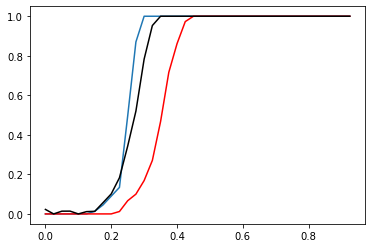

In [12]:
plt.plot(power_ma.d, power_ma.power_randslope)
plt.plot(power_ma.d, power_ma.power_rm, 'r')
plt.plot(power_ma.d, power_ma.power_ez, 'k')


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(results_sim.cohensd_int[:, np.newaxis], results_sim.int_param)
print(lr.coef_, lr.intercept_)

lr.intercept_ + lr.coef_[0]*.2

In [ ]:
lr.predict(np.array([.5]).reshape((1,1)))

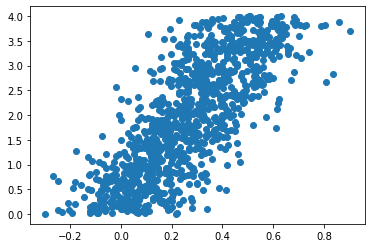

In [13]:
plt.scatter(results_sim.cohensd_int, results_sim.int_param)